In [1]:
import itertools
import math
import warnings
import random

from math import ceil

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from scipy.special import comb
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score,f1_score, make_scorer
from sklearn.preprocessing import OneHotEncoder

from my_awesome_eda import run_eda

In [ ]:
pip install -U matplotlib seaborn xgboost lightgbm catboost scikit-learn gdown

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

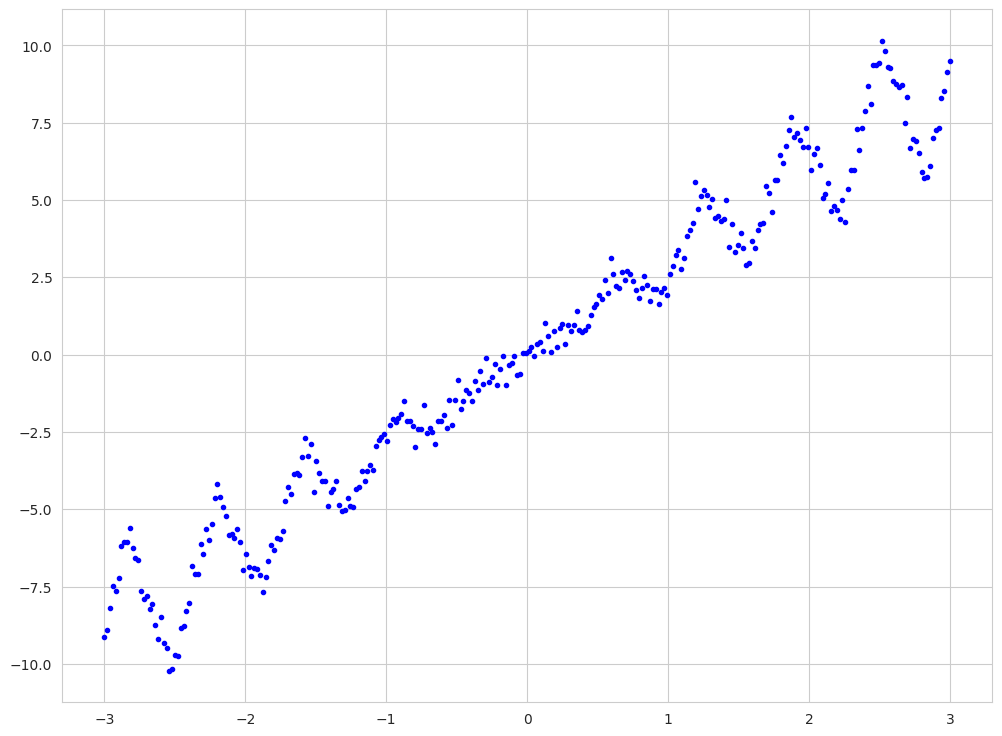

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(X, y, ranges, axes=[-3, 3, -10, 10], ylabel="$y$"):

    for i in ranges:
        tree_reg = DecisionTreeRegressor(max_depth=i).fit(X, y)
        x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
        y_pred = tree_reg.predict(x1)
        plt.axis(axes)
        plt.xlabel("$x_1$", fontsize=18)
        if ylabel:
            plt.ylabel(ylabel, fontsize=18, rotation=0)

        plt.plot(x1, y_pred, linewidth=2, label=i)
        plt.legend()

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

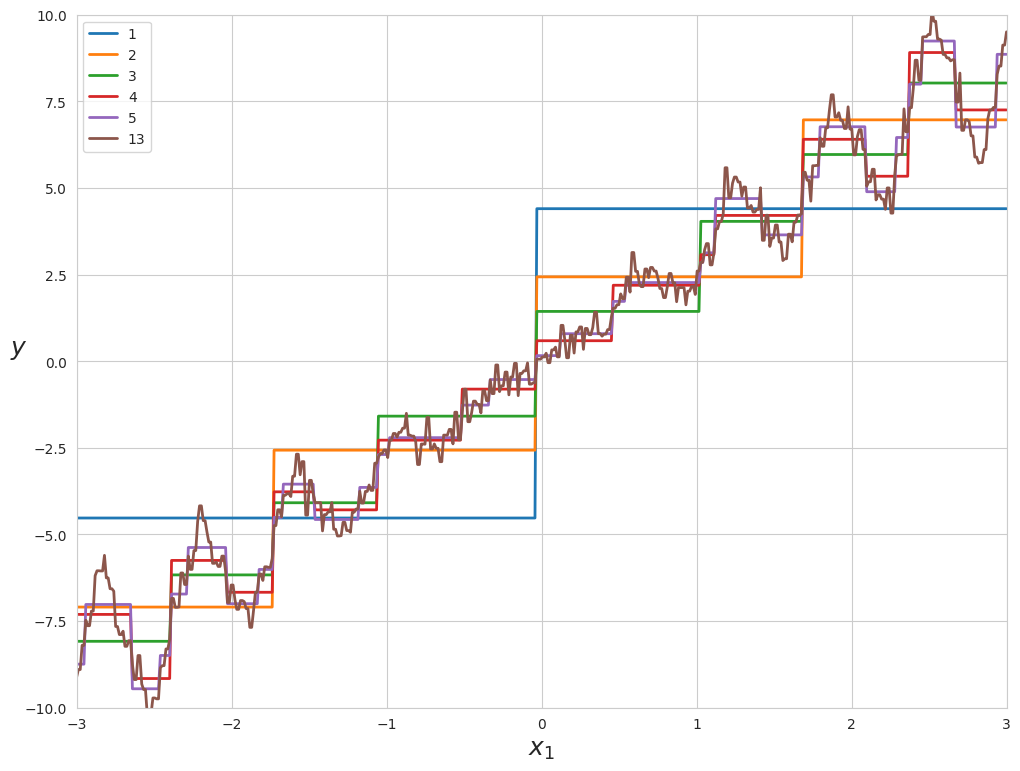

In [5]:
plot_regression_predictions(X, y, [1,2,3,4,5,13])

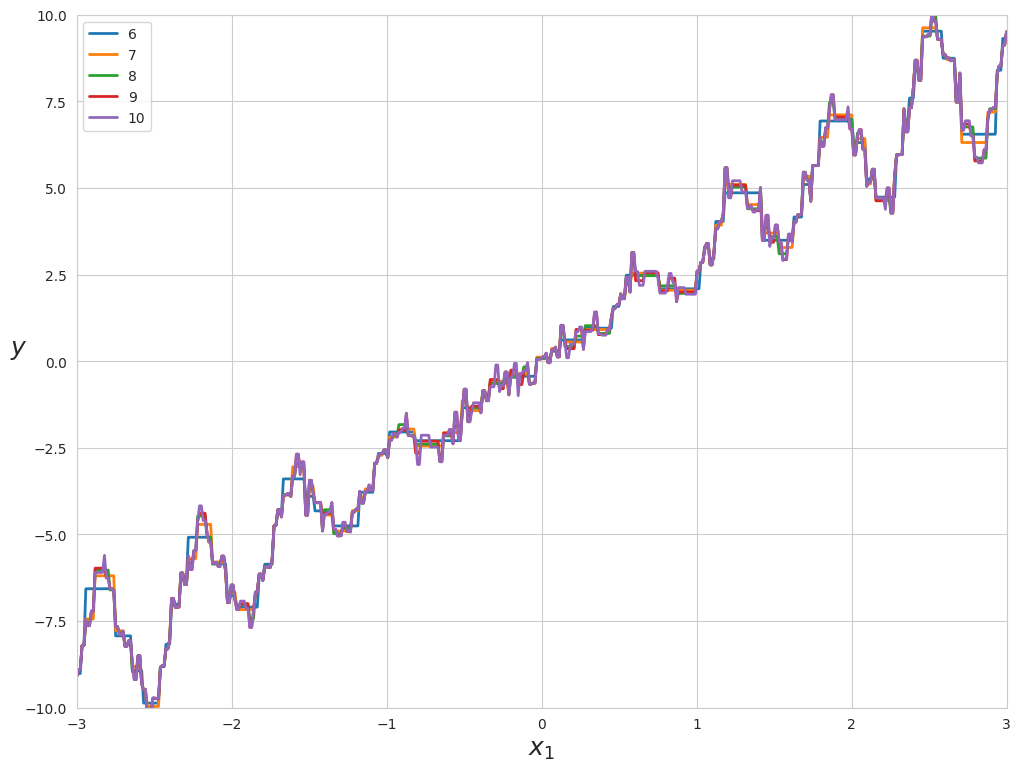

In [6]:
plot_regression_predictions(X, y, [6,7,8,9,10])

Чем больше глубина, тем меньше обощающая способность, но тем больше variance и меньше bias.

Чем меньше глубина, тем больше обощающая способность. Однако до depth=4 все слишком сильно сводится к среднему (получается мы не попадем в цель, берем среднее - то есть variance не будет высоким, а вот bias - да)

Приведенные графики с низким depth хорошо демонстрируют bias trade-off. Variance tarde-off отчетливо виден уже на depth=9 - произошло уже явное переобучение и мы ловим не только тренд графика, но и более мелкие точки. Совсем оптимальным вариантом кажется depth=8, тут явный баланс между variance и bias trade-off

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
def probability_correct_classification(p, n):
    probabilities = []
    for k in range(ceil(n/2), n + 1):
        prob = comb(n, k) * (p ** k) * ((1 - p) ** (n - k))
        probabilities.append(prob)
    return sum(probabilities)

In [8]:
# Значения p от 0 до 1 с шагом 0.01
p_values = np.linspace(0, 1, 1000)
# Количество классификаторов
n_classifiers = 101
# Вычисляем вероятности правильной классификации для каждого значения p
p_ = [probability_correct_classification(p, n_classifiers) for p in p_values]


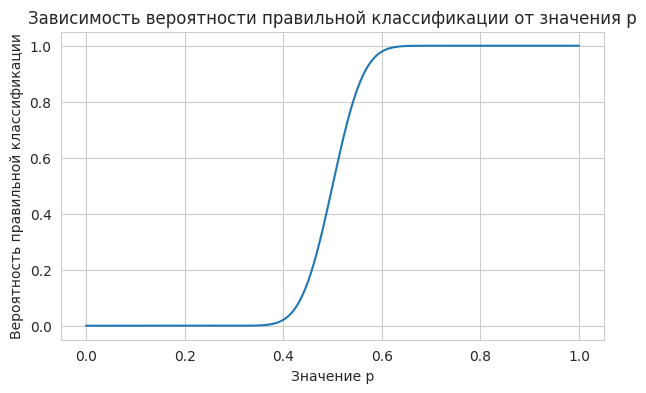

In [9]:
#Рисуем красивое (/¯◡ ‿ ◡)/¯☆*
plt.figure(figsize=(7,4))
plt.plot(p_values, p_)
plt.xlabel('Значение p')
plt.ylabel('Вероятность правильной классификации')
plt.title('Зависимость вероятности правильной классификации от значения p')
plt.grid(True)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

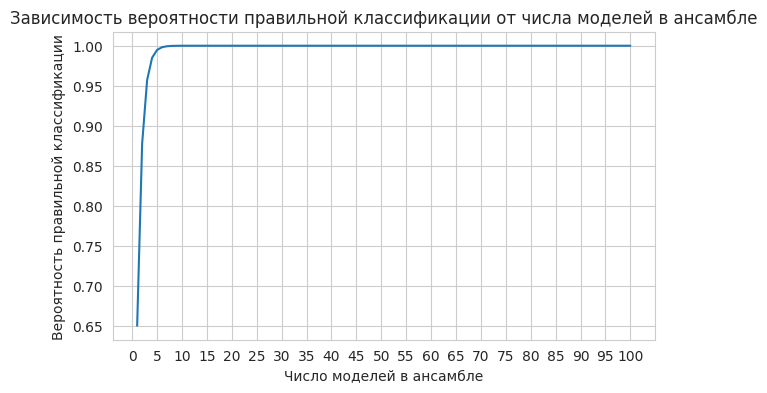

In [85]:
def calculate_classification_probability(p_single_model, num_models):
    return 1 - (1 - p_single_model) ** num_models

# Фиксированная вероятность правильной классификации объекта одной моделью
p_single_model = 0.65

# Список числа моделей в ансамбле
num_models_list = list(range(1, 101))

# Расчет вероятности правильной классификации для каждого числа моделей
classification_probabilities = [calculate_classification_probability(p_single_model, num_models) for num_models in num_models_list]

# Рисуем красивое (/¯◡ ‿ ◡)/¯☆*
plt.figure(figsize=(7,4))
plt.plot(num_models_list, classification_probabilities)
plt.xlabel('Число моделей в ансамбле')
plt.ylabel('Вероятность правильной классификации')
plt.title('Зависимость вероятности правильной классификации от числа моделей в ансамбле')
plt.xticks(np.arange(0, 101, 5))
plt.grid(True)
plt.show()

Опишите ваши наблюдения:

* Если у каждой модели вероятность меньше 0.4, то их предсказания в ансамбле  не улучшают друг друга.  Это происходит потому, что вероятность правильной классификации каждой модели настолько низкая, что предсказания моделей не имеют достаточной уверенности, чтобы улучшить предсказания друг друга. В таком случае ансамбль даже может показать худшие результаты, чем отдельные модели.
* Далее предсказания резко улучшаются и при вероятности 0,6 у каждой 101 модели - выходят на плато. Это происходит потому, что с увеличением вероятности правильной классификации отдельной модели ее предсказания становятся более надежными и информативными.
* Похожее плато наблюдается и для количества моделей с одинковой вероятностью. Как видно на графике, максимум достигается при использовании уже весго 5 моделей

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [89]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []


    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))

        for i in range(self.n_estimators):
            #Зафиксируйте генератор случайных чисел
            np.random.seed(self.random_state + i)

            #выберите max_features признаков
            feat_ids = np.random.choice(X.shape[1], self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)

            #создайте псевдовыборку при помощи бутстрэпа
            bootstrap_indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]

            #Обучите дерево решений
            tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, random_state=self.random_state)
            tree.fit(X_bootstrap[:, feat_ids], y_bootstrap)

            self.trees.append(tree)
        return self


    def predict_proba(self, X):
        probas = []
        for tree, feat_ids in zip(self.trees, self.feat_ids_by_tree):
            proba = tree.predict_proba(X[:, feat_ids])
            probas.append(proba)
        avg_proba = np.mean(probas, axis=0)
        return avg_proba


    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [90]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

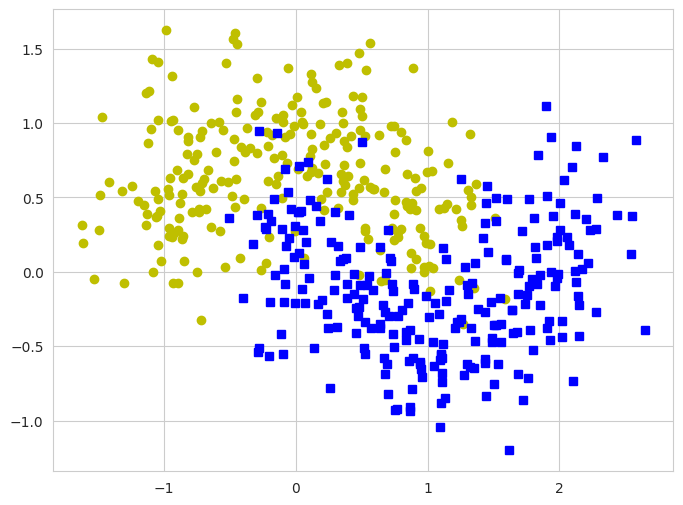

In [35]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

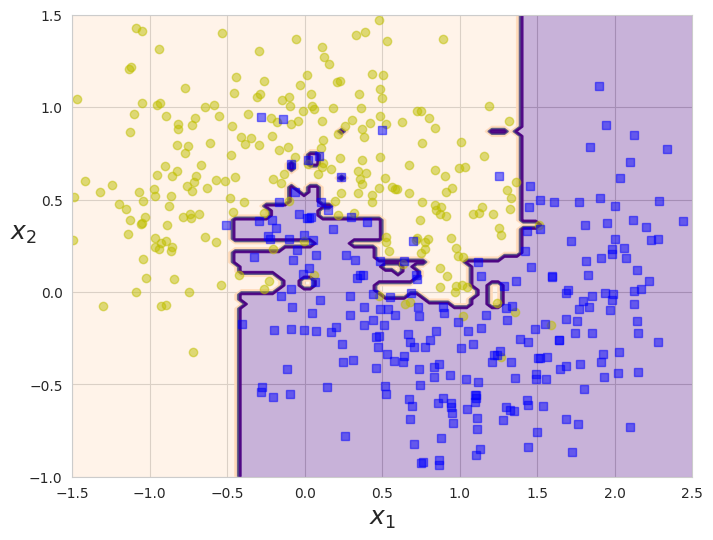

In [91]:
# создаем RandomForestClassifierCustom
clf = RandomForestClassifierCustom(n_estimators=10, max_depth=15, max_features=2, random_state=SEED)

# делаем предсказание
clf.fit(X, y)

#Рисуем красивое (/¯◡ ‿ ◡)/¯☆*
plt.figure(figsize=(8, 6))
plot_decision_boundary(clf, X, y)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

Best Parameters: {'max_depth': 7, 'n_estimators': 50}
Best Score: 0.9291072508459315


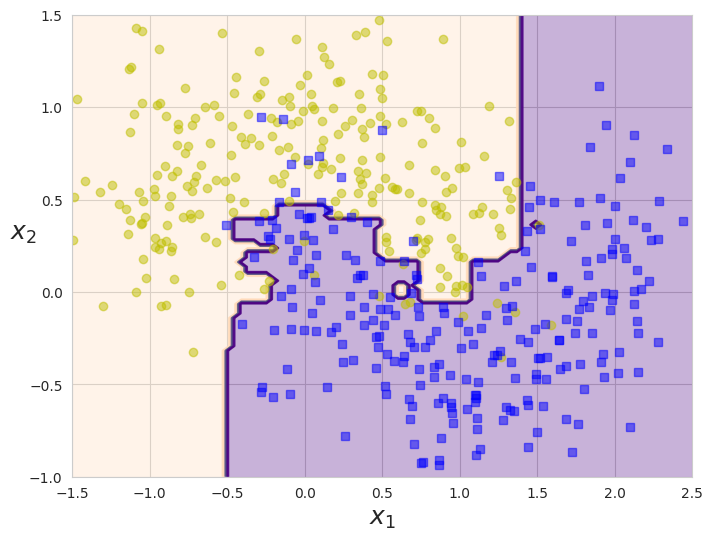

(None,)

In [92]:
# custom_scorer = make_scorer(accuracy_score)
custom_scorer = make_scorer(f1_score)

# Задаем параметры для grid_search
param_grid = {
    'n_estimators': [5, 10, 50, 100],
    'max_depth': range(3, 15)
}

# создаем RandomForestClassifierCustom
clf = RandomForestClassifierCustom(random_state=SEED, max_features=2)
# создаем grid_search с параметрами

grid_search = GridSearchCV(clf, param_grid, cv=10, scoring=custom_scorer, verbose=0)

# подибираем параметры grid_search
grid_search.fit(X, y)

# Печатаем лушчий скор
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Сохраняем и рисуем лучшую
best_clf = grid_search.best_estimator_

plt.figure(figsize=(8, 6))
plot_decision_boundary(best_clf, X, y)
plt.show(),

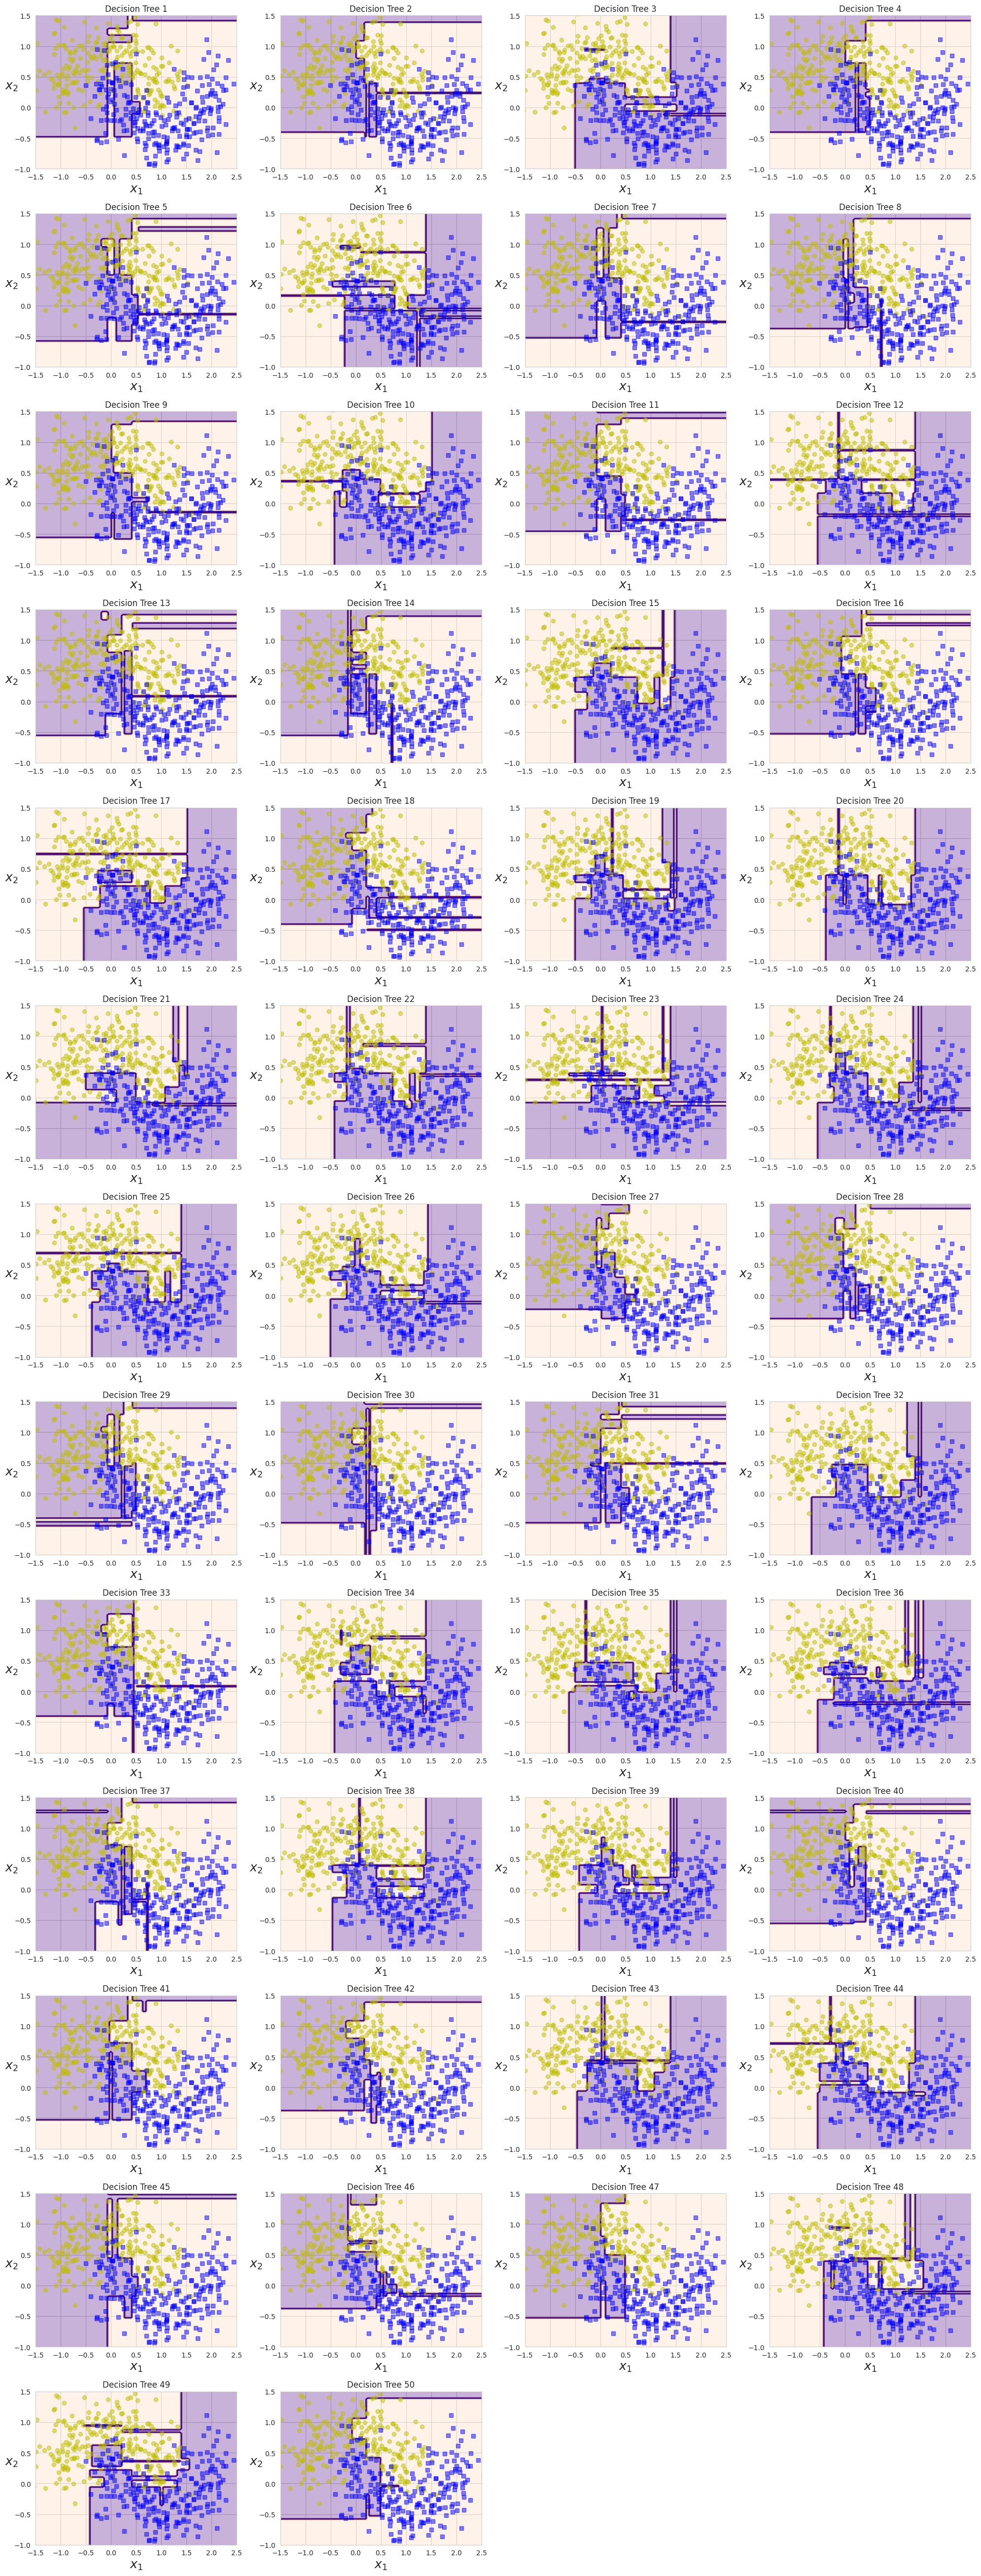

In [88]:
num_trees = len(best_clf.trees)

plt.figure(figsize=(20, num_trees*2))

for i, tree in enumerate(best_clf.trees):
    plt.subplot(num_trees//2, 4, i+1)  # Создаем подграфик в определенной позиции
    plot_decision_boundary(tree, X, y)  # Рисуем границу решения для данного дерева
    plt.title(f'Decision Tree {i+1}')  # Устанавливаем заголовок

    plt.tight_layout()  # Корректируем расположение подграфиков
plt.show()


#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [93]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [94]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(426, 30)

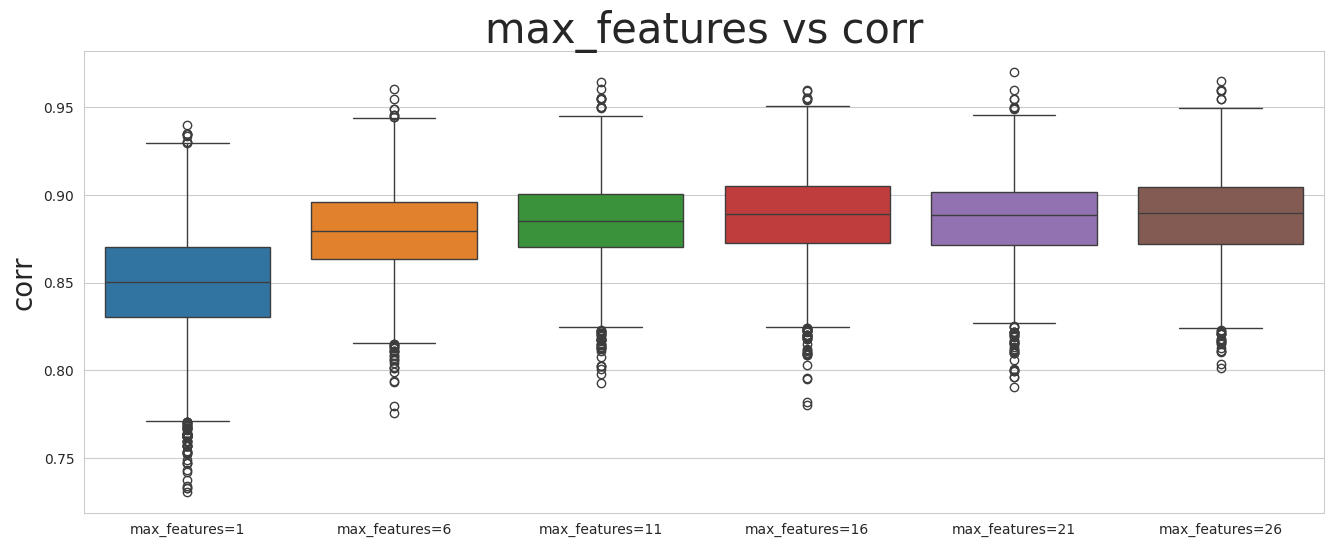

In [95]:
models_rf = {}

for i in range(1, 31, 5):
    model = RandomForestClassifier(max_features=i,
                                   random_state=42,
                                   n_jobs=-1).fit(X_train, y_train)

    models_rf[f"max_features={i}"] = base_model_pair_correlation(model, X_train)

data=pd.DataFrame(models_rf)

plt.figure(figsize=(16,6))
sns.boxplot(data=data)
plt.xlabel("", size=20)
plt.ylabel("corr", size=20)
plt.title("max_features vs corr", size=30)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

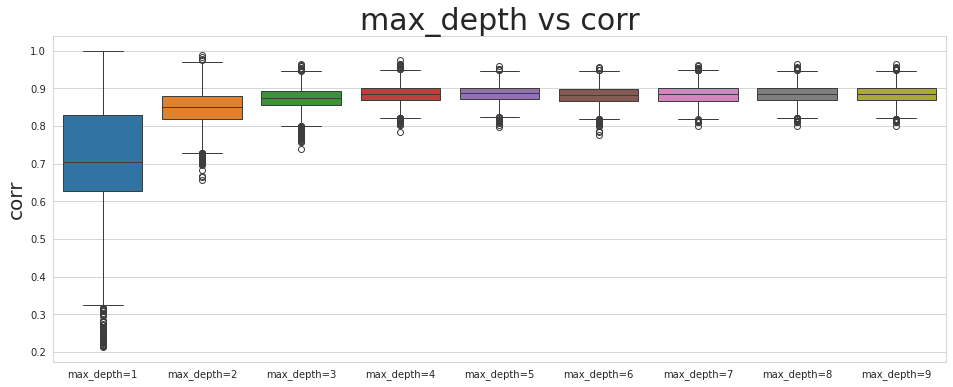

In [ ]:
models_rf = {}

for i in range(10):
    model = RandomForestClassifier(max_depth=i,
                                   random_state=42,
                                   n_jobs=-1).fit(X_train, y_train)

    models_rf[f"max_depth={i}"] = base_model_pair_correlation(model, X_train)

data=pd.DataFrame(models_rf)

plt.figure(figsize=(16,6))
sns.boxplot(data=data)
plt.xlabel("", size=20)
plt.ylabel("corr", size=20)
plt.title("max_depth vs corr", size=30)
plt.show()

Опишите ваши наблюдения:

*  Деревья с большим max_features лучше подстраиваются под обучающие данные, хорошо коррелируют друг с другом и легко переобучаются.

*  Деревья с большим max_depth могут иметь большую гибкость и лучше подстраиваются под обучающие данные. Это может привести к высокой корреляции между деревьями, если не играть с отбором признаков (как раз с упомянутым выше max_features, в идеале с использованием бустрепа) для каждого дерева.При этом менее глубокие деревья могут ограничивать модель и уменьшать корреляцию между деревьями, но могут быть менее точными.

* Таким образом, увеличение max_features и увеличение max_depth в случайном лесу склонно увеличивать корреляцию между базовыми моделями, что потенциально даст нам почти одинаковые деревья в нашем лесу. Это не очень хорошо, поэтому в Random Forest принято ограничивать количество max_features, а также перемешивать их (без повторений). При это max_depth как правило не ограничивают, так как переобучение на каждых уникальных данных как раз сгладится в случайном лесу

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [ ]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

/opt/conda/lib/python3.8/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [ ]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
178   43    1   0       120   177    0        0      120      1      2.5   
298   57    0   0       140   241    0        1      123      1      0.2   
201   60    1   0       125   258    0        0      141      1      2.8   
246   56    0   0       134   409    0        0      150      1      1.9   
153   66    0   2       146   278    0        0      152      0      0.0   

     slope  ca  thal  
178      1   0     3  
298      1   0     3  
201      1   1     3  
246      1   2     3  
153      1   1     2

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [ ]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED,verbose=-1)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED,verbose=-1)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf),
               ("ETC", etc), ("KNN", knn),
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),
               ("CAT", cat), ("LGBM", lgbm),
               ("LGBM_RF", lgbm_rf), ("XGB", xgb),
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

Получилось заставить его замолчать! 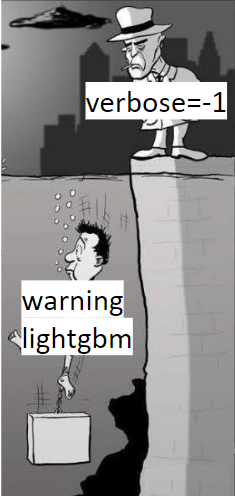

In [ ]:
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]:
    model=model.fit(X_train, y_train)

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]:
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8499478840942255
LGBMClassifier: 0.8132478632478634
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8494440278941667
VotingClassifier: 0.8455110375195781


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [ ]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [ ]:
corr=base_model_pair_correlation_for_voting_clf(voting_hard, X_test)


In [ ]:
#выведем модели, у которых корреляция больше 0.9
for models in corr:
    if models[2] > 0.90:
        print(type(models[0]).__name__,'vs',type(models[1]).__name__)
        print("--------------------------")

RandomForestClassifier vs ExtraTreesClassifier
--------------------------
RandomForestClassifier vs CatBoostClassifier
--------------------------
RandomForestClassifier vs LGBMClassifier
--------------------------
RandomForestClassifier vs LGBMClassifier
--------------------------
RandomForestClassifier vs XGBRFClassifier
--------------------------
ExtraTreesClassifier vs CatBoostClassifier
--------------------------
SVC vs LogisticRegression
--------------------------
CatBoostClassifier vs LGBMClassifier
--------------------------
CatBoostClassifier vs XGBClassifier
--------------------------
CatBoostClassifier vs XGBRFClassifier
--------------------------
LGBMClassifier vs XGBClassifier
--------------------------
LGBMClassifier vs XGBRFClassifier
--------------------------
LGBMClassifier vs XGBRFClassifier
--------------------------
XGBClassifier vs XGBRFClassifier
--------------------------


In [ ]:
#уберем те из base_models, что коррелируют со многими: RandomForestClassifier CatBoostClassifier LGBMClassifier
base_models = [("DT", dt),
               ("ETC", etc), ("KNN", knn),
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),

               ("LGBM_RF", lgbm_rf), ("XGB", xgb),
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_hard.fit(X_train, y_train)
print(f1_score(y_test,voting_hard.predict(X_test)))

voting_soft = VotingClassifier(estimators=base_models, voting='soft')
voting_soft.fit(X_train, y_train)
print(f1_score(y_test,voting_soft.predict(X_test)))

0.8823529411764706
0.8737864077669905


In [ ]:
scores = []
for r in range(4, len(base_models)):
    combinations = list(itertools.combinations(base_models, r))
    for models in combinations:

        voting_hard = VotingClassifier(estimators=list(models), voting='hard')
        voting_hard.fit(X_train, y_train)
        scores.append([models,f1_score(y_test,voting_hard.predict(X_test))])

data=pd.DataFrame(scores).sort_values(by=[1])
print('best score:',data.iloc[-1][1])
data.iloc[-1][0]

best score: 0.9278350515463918


(('ETC', ExtraTreesClassifier(random_state=111)),
 ('XGB_RF',
  XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                  colsample_bylevel=None, colsample_bytree=None, device=None,
                  early_stopping_rounds=None, enable_categorical=False,
                  eval_metric=None, feature_types=None, gamma=None,
                  grow_policy=None, importance_type=None,
                  interaction_constraints=None, max_bin=None,
                  max_cat_threshold=None, max_cat_to_onehot=None,
                  max_delta_step=None, max_depth=None, max_leaves=None,
                  min_child_weight=None, missing=nan, monotone_constraints=None,
                  multi_strategy=None, n_estimators=None, n_jobs=None,
                  num_parallel_tree=None, objective='binary:logistic',
                  random_state=111, reg_alpha=None, ...)),
 ('LR', LogisticRegression(max_iter=10000, solver='liblinear')),
 ('NB', GaussianNB()))

In [ ]:
scores = []
for r in range(4, len(base_models)):
    combinations = list(itertools.combinations(base_models, r))
    for models in combinations:

        voting_soft = VotingClassifier(estimators=list(models), voting='soft')
        voting_soft.fit(X_train, y_train)
        scores.append([models,f1_score(y_test,voting_soft.predict(X_test))])

data=pd.DataFrame(scores).sort_values(by=[1])
print('best score:',data.iloc[-1][1])
data.iloc[-1][0]

best score: 0.8979591836734694


(('ETC', ExtraTreesClassifier(random_state=111)),
 ('SVC_LIN', SVC(kernel='linear', probability=True, random_state=111)),
 ('SVC_RBF', SVC(probability=True, random_state=111)),
 ('NB', GaussianNB()))

In [ ]:
base_models_hard = [("ETC", etc),("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

voting_hard = VotingClassifier(estimators=base_models_hard, voting='hard')
voting_hard.fit(X_train, y_train)
print(f1_score(y_test,voting_hard.predict(X_test)))

base_models_soft = [("ETC", etc), ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),("NB", nb)]

voting_soft = VotingClassifier(estimators=base_models_soft, voting='soft')
voting_soft.fit(X_train, y_train)
print(f1_score(y_test,voting_soft.predict(X_test)))

0.9278350515463918
0.8979591836734694


Ура, лучший скор 0.927 :) При voiting = hard и следующих моделей в ансамбле:
*  ExtraTreesClassifier
*  XGBRFClassifier
*  LogisticRegression
*  GaussianNB

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель.

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [97]:
data = pd.read_csv("./data/churn.csv")
data.head()

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.  

[5 rows x 21 columns]

In [98]:
data.shape

(3333, 21)

In [99]:
data.dtypes.value_counts()

int64      8
float64    8
object     5
dtype: int64

Hi! I will give you some basic summary of your  dataset. 
   Shape: 3333 rows x 21 columns 


***** Data Types in Columns *****
State             category
Account Length    category
Area Code         category
Phone               object
Int'l Plan        category
VMail Plan        category
VMail Message     category
Day Mins           float64
Day Calls         category
Day Charge         float64
Eve Mins           float64
Eve Calls         category
Eve Charge         float64
Night Mins         float64
Night Calls       category
Night Charge       float64
Intl Mins         category
Intl Calls        category
Intl Charge       category
CustServ Calls    category
Churn?            category




***** Main Statistics on Categorical Columns ***** 
                counts  frequencies
State               51     0.015302
Account Length     212     0.063606
Area Code            3     0.000900
Int'l Plan           2     0.000600
VMail Plan           2     0.000600
VMail Message       46     0.0138

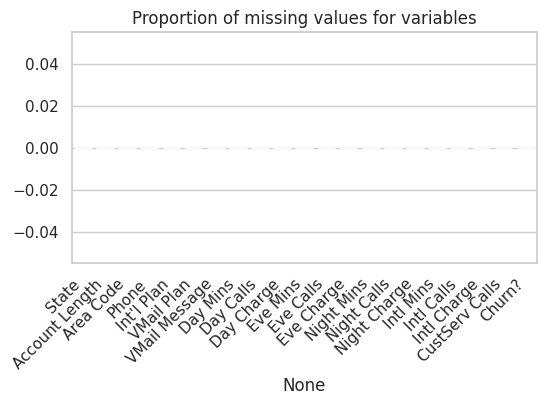

Quantity of  rows with missing values: 0
Columns with missing values: []
Duplicate rows in df: 0


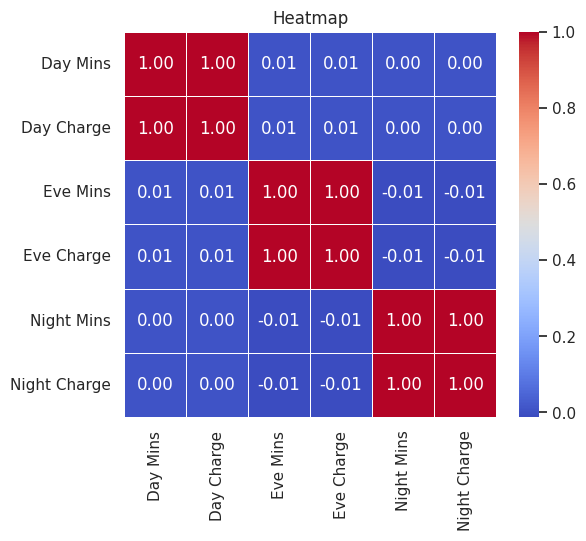

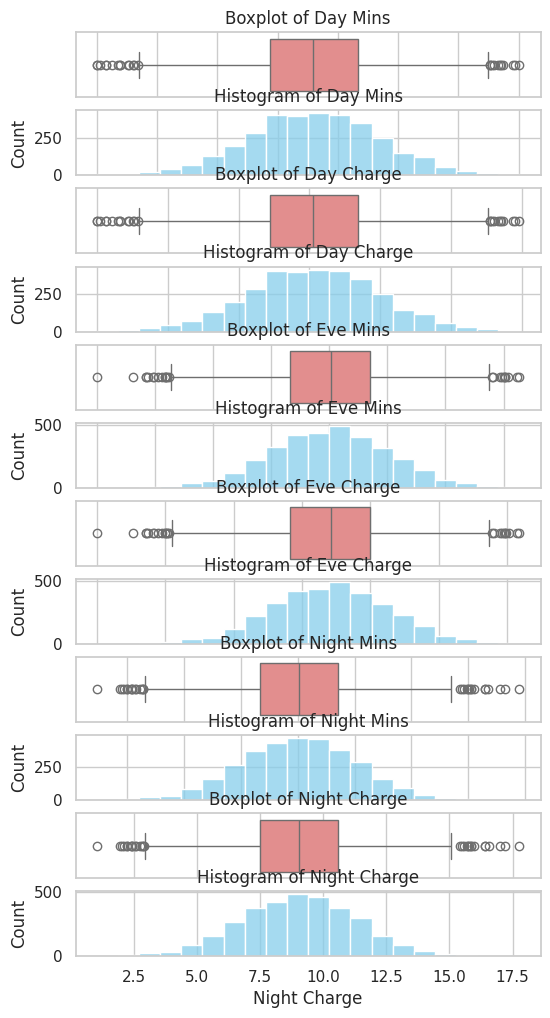

In [ ]:
run_eda(data)

In [ ]:
data.groupby('State').count()['Account Length']

In [ ]:
data['Churn?'].value_counts() #явный дисбаланс классов

False.    2850
True.      483
Name: Churn?, dtype: int64

In [101]:
df = data.groupby(['State', 'Churn?'])['Account Length'].count().unstack()
df['Percent True'] = (df['True.'] / (df['True.'] + df['False.'])) * 100
df['Percent False'] = (df['False.'] / (df['True.'] + df['False.'])) * 100
df # этот признак по-разному распределен - попробуем его оставить и закодировать OneHotEncoder

Churn?  False.  True.  Percent True  Percent False
State                                             
AK          49      3      5.769231      94.230769
AL          72      8     10.000000      90.000000
AR          44     11     20.000000      80.000000
AZ          60      4      6.250000      93.750000
CA          25      9     26.470588      73.529412
CO          57      9     13.636364      86.363636
CT          62     12     16.216216      83.783784
DC          49      5      9.259259      90.740741
DE          52      9     14.754098      85.245902
FL          55      8     12.698413      87.301587
GA          46      8     14.814815      85.185185
HI          50      3      5.660377      94.339623
IA          41      3      6.818182      93.181818
ID          64      9     12.328767      87.671233
IL          53      5      8.620690      91.379310
IN          62      9     12.676056      87.323944
KS          57     13     18.571429      81.428571
KY          51      8     13.559322      86.440678
LA          47      4      7.843137      92.156863
MA          54     11     16.923077      83.076923
MD          53     17     24.285714      75.714286
ME          49     13     20.967742      79.032258
MI          57     16     21.917808      78.082192
MN          69     15     17.857143      82.142857
MO          56      7     11.111111      88.888889
MS          51     14     21.538462      78.461538
MT          54     14     20.588235      79.411765
NC          57     11     16.176471      83.823529
ND          56      6      9.677419      90.322581
NE          56      5      8.196721      91.803279
NH          47      9     16.071429      83.928571
NJ          50     18     26.470588      73.529412
NM          56      6      9.677419      90.322581
NV          52     14     21.212121      78.787879
NY          68     15     18.072289      81.927711
OH          68     10     12.820513      87.179487
OK          52      9     14.754098      85.245902
OR          67     11     14.102564      85.897436
PA          37      8     17.777778      82.222222
RI          59      6      9.230769      90.769231
SC          46     14     23.333333      76.666667
SD          52      8     13.333333      86.666667
TN          48      5      9.433962      90.566038
TX          54     18     25.000000      75.000000
UT          62     10     13.888889      86.111111
VA          72      5      6.493506      93.506494
VT          65      8     10.958904      89.041096
WA          52     14     21.212121      78.787879
WI          71      7      8.974359      91.025641
WV          96     10      9.433962      90.566038
WY          68      9     11.688312      88.311688

In [ ]:
data['Phone'].nunique() #этот признак уникален, удалим его

3333

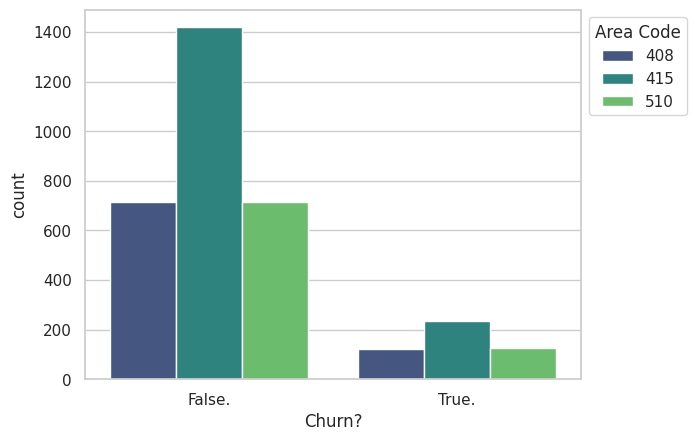

In [ ]:
ax = sns.countplot(data=data, x='Churn?',
            hue='Area Code', palette='viridis',
           );

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
df = data.groupby(['Area Code', 'Churn?'])['Account Length'].count().unstack()
df['Percent True'] = (df['True.'] / (df['True.'] + df['False.'])) * 100
df['Percent False'] = (df['False.'] / (df['True.'] + df['False.'])) * 100
df # этот признак можно удалить, он распределен между классами практически одинаково

Churn?     False.  True.  Percent True  Percent False
Area Code                                            
408           716    122     14.558473      85.441527
415          1419    236     14.259819      85.740181
510           715    125     14.880952      85.119048

In [107]:
heart_dataset = data.drop(columns=['Phone', 'Area Code', 'State'])
heart_dataset['Churn?']=heart_dataset['Churn?'].apply(lambda x:1 if x=="True." else 0)
heart_dataset["Int'l Plan"]=heart_dataset["Int'l Plan"].apply(lambda x:1 if x=="yes" else 0 ).astype("int")
heart_dataset['VMail Plan']=heart_dataset['VMail Plan'].apply(lambda x:1 if x=="yes" else 0 ).astype("int")
heart_dataset['Account Length'] = heart_dataset['Account Length'].astype("int")
heart_dataset['VMail Message'] = heart_dataset['VMail Message'].astype("int")
heart_dataset['Eve Calls'] = heart_dataset['Eve Calls'].astype("int")
heart_dataset['Day Calls'] = heart_dataset['Day Calls'].astype("int")
heart_dataset['Night Calls'] = heart_dataset['Night Calls'].astype("int")
heart_dataset['Intl Calls'] = heart_dataset['Intl Calls'].astype("int")
heart_dataset['Intl Mins'] = heart_dataset['Intl Mins'].astype("float64")
heart_dataset['Intl Charge'] = heart_dataset['Intl Charge'].astype("float64")
heart_dataset['CustServ Calls'] = heart_dataset['CustServ Calls'].astype("int")
heart_dataset.head()

Account Length  Int'l Plan  VMail Plan  VMail Message  Day Mins  Day Calls  \
0             128           0           1             25     265.1        110   
1             107           0           1             26     161.6        123   
2             137           0           0              0     243.4        114   
3              84           1           0              0     299.4         71   
4              75           1           0              0     166.7        113   

   Day Charge  Eve Mins  Eve Calls  Eve Charge  Night Mins  Night Calls  \
0       45.07     197.4         99       16.78       244.7           91   
1       27.47     195.5        103       16.62       254.4          103   
2       41.38     121.2        110       10.30       162.6          104   
3       50.90      61.9         88        5.26       196.9           89   
4       28.34     148.3        122       12.61       186.9          121   

   Night Charge  Intl Mins  Intl Calls  Intl Charge  CustServ Calls  Churn?  
0         11.01       10.0           3         2.70               1       0  
1         11.45       13.7           3         3.70               1       0  
2          7.32       12.2           5         3.29               0       0  
3          8.86        6.6           7         1.78               2       0  
4          8.41       10.1           3         2.73               3       0

### Датасет без признака State

In [137]:
X = heart_dataset.drop("Churn?", axis=1)
y = heart_dataset["Churn?"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y) #добавила, так как сильный дисбаланс классов)
X_train.head()

Account Length  Int'l Plan  VMail Plan  VMail Message  Day Mins  \
633              122           0           1             34     146.4   
2704              72           0           0              0     141.3   
1642              99           0           0              0      54.8   
2503             168           0           0              0     183.2   
2034              60           0           0              0     145.0   

      Day Calls  Day Charge  Eve Mins  Eve Calls  Eve Charge  Night Mins  \
633         104       24.89      89.7        103        7.62       220.0   
2704        133       24.02     134.9         96       11.47       227.5   
1642         92        9.32     173.0        103       14.71       195.1   
2503        131       31.14     179.2         73       15.23       292.8   
2034        133       24.65     209.1         92       17.77       328.5   

      Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
633            91          9.90       15.6           4         4.21   
2704           97         10.24       11.2           3         3.02   
1642          125          8.78        7.5           3         2.03   
2503          100         13.18        9.9           5         2.67   
2034          112         14.78       14.6           2         3.94   

      CustServ Calls  
633                2  
2704               2  
1642               1  
2503               2  
2034               1

In [138]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED).fit(X_train,y_train)
print(f1_score(y_test,cat.predict(X_test)))

xgb_rf = xgboost.XGBRFClassifier(random_state=SEED, enable_categorical=True).fit(X_train,y_train)
print(f1_score(y_test,xgb_rf.predict(X_test)))


0.8687782805429864
0.777292576419214


Добавим State для catboost

In [122]:
heart_dataset_expanded = heart_dataset.join(data[['State']]).astype("object")
X_ = heart_dataset_expanded.drop("Churn?", axis=1)
y_ = heart_dataset_expanded["Churn?"]
X_train, X_test, y_train, y_test = train_test_split(X_, y_, random_state=SEED, stratify=y_) #добавила, так как сильный дисбаланс классов)
X_train.head()

Account Length Int'l Plan VMail Plan VMail Message Day Mins Day Calls  \
633             122          0          1            34    146.4       104   
2704             72          0          0             0    141.3       133   
1642             99          0          0             0     54.8        92   
2503            168          0          0             0    183.2       131   
2034             60          0          0             0    145.0       133   

     Day Charge Eve Mins Eve Calls Eve Charge Night Mins Night Calls  \
633       24.89     89.7       103       7.62      220.0          91   
2704      24.02    134.9        96      11.47      227.5          97   
1642       9.32    173.0       103      14.71      195.1         125   
2503      31.14    179.2        73      15.23      292.8         100   
2034      24.65    209.1        92      17.77      328.5         112   

     Night Charge Intl Mins Intl Calls Intl Charge CustServ Calls State  
633           9.9      15.6          4        4.21              2    NJ  
2704        10.24      11.2          3        3.02              2    OR  
1642         8.78       7.5          3        2.03              1    TN  
2503        13.18       9.9          5        2.67              2    IN  
2034        14.78      14.6          2        3.94              1    MT

In [135]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED, cat_features = ['State']).fit(X_train,y_train)
print(f1_score(y_test.astype('int'), cat.predict(X_test)))

0.8636363636363636


Добавим данные OneHotEncoder для xgboost (Да, идея расширять так датасет на 49 столбцов странная - просто попробую из интереса)

In [109]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

encoder_df = pd.DataFrame(encoder. fit_transform(data[['State']]).toarray ())

#merge one-hot и наши данные
heart_dataset_expanded_2 =  heart_dataset.join(encoder_df) #
heart_dataset_expanded_2

Account Length Int'l Plan VMail Plan VMail Message Day Mins Day Calls  \
0               128          0          1            25    265.1       110   
1               107          0          1            26    161.6       123   
2               137          0          0             0    243.4       114   
3                84          1          0             0    299.4        71   
4                75          1          0             0    166.7       113   
...             ...        ...        ...           ...      ...       ...   
3328            192          0          1            36    156.2        77   
3329             68          0          0             0    231.1        57   
3330             28          0          0             0    180.8       109   
3331            184          1          0             0    213.8       105   
3332             74          0          1            25    234.4       113   

     Day Charge Eve Mins Eve Calls Eve Charge Night Mins Night Calls  \
0         45.07    197.4        99      16.78      244.7          91   
1         27.47    195.5       103      16.62      254.4         103   
2         41.38    121.2       110       10.3      162.6         104   
3          50.9     61.9        88       5.26      196.9          89   
4         28.34    148.3       122      12.61      186.9         121   
...         ...      ...       ...        ...        ...         ...   
3328      26.55    215.5       126      18.32      279.1          83   
3329      39.29    153.4        55      13.04      191.3         123   
3330      30.74    288.8        58      24.55      191.9          91   
3331      36.35    159.6        84      13.57      139.2         137   
3332      39.85    265.9        82       22.6      241.4          77   

     Night Charge Intl Mins Intl Calls Intl Charge CustServ Calls Churn? State  
0           11.01      10.0          3         2.7              1      0    KS  
1           11.45      13.7          3         3.7              1      0    OH  
2            7.32      12.2          5        3.29              0      0    NJ  
3            8.86       6.6          7        1.78              2      0    OH  
4            8.41      10.1          3        2.73              3      0    OK  
...           ...       ...        ...         ...            ...    ...   ...  
3328        12.56       9.9          6        2.67              2      0    AZ  
3329         8.61       9.6          4        2.59              3      0    WV  
3330         8.64      14.1          6        3.81              2      0    RI  
3331         6.26       5.0         10        1.35              2      0    CT  
3332        10.86      13.7          4         3.7              0      0    TN  

[3333 rows x 19 columns]

In [114]:
X_ = heart_dataset_expanded_2.drop("Churn?", axis=1)
y_ = heart_dataset_expanded_2["Churn?"]
X_train, X_test, y_train, y_test = train_test_split(X_, y_, random_state=SEED, stratify=y_) #добавила, так как сильный дисбаланс классов)
X_train.head()

Account Length  Int'l Plan  VMail Plan  VMail Message  Day Mins  \
633              122           0           1             34     146.4   
2704              72           0           0              0     141.3   
1642              99           0           0              0      54.8   
2503             168           0           0              0     183.2   
2034              60           0           0              0     145.0   

      Day Calls  Day Charge  Eve Mins  Eve Calls  Eve Charge  ...   40   41  \
633         104       24.89      89.7        103        7.62  ...  0.0  0.0   
2704        133       24.02     134.9         96       11.47  ...  0.0  0.0   
1642         92        9.32     173.0        103       14.71  ...  0.0  1.0   
2503        131       31.14     179.2         73       15.23  ...  0.0  0.0   
2034        133       24.65     209.1         92       17.77  ...  0.0  0.0   

       42   43   44   45   46   47   48   49  
633   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2704  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1642  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2503  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2034  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 67 columns]

In [115]:
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED, enable_categorical=True).fit(X_train,y_train)
print(f1_score(y_test,xgb_rf.predict(X_test)))

0.7792207792207793


Добавление 'State' не улучшило метрику качества моделей. Поэтому буду делать grid_search на данных без State

In [ ]:
X = heart_dataset.drop("Churn?", axis=1)
y = heart_dataset["Churn?"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, stratify=y) #добавила, так как сильный дисбаланс классов)
X_train.head()

In [154]:
cat = catboost.CatBoostClassifier(random_seed=SEED)

param_grid = {
    'learning_rate': [None, 0.05, 0.1, 0.2],
    'depth': [None, 4, 6, 8, 10],
    'iterations': [None, 10, 50, 100]
}


grid_search = GridSearchCV(cat, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=3)

# ищем лучшие параметры
grid_search.fit(X_train, y_train)

# печатаем их
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 3 folds for each of 80 candidates, totalling 240 fits
0:	learn: 0.5867832	total: 8.57ms	remaining: 8.56s
1:	learn: 0.5255104	total: 12.1ms	remaining: 6.04s
2:	learn: 0.4618036	total: 15.7ms	remaining: 5.22s
3:	learn: 0.4171372	total: 19.2ms	remaining: 4.77s
4:	learn: 0.3838705	total: 23.6ms	remaining: 4.69s
5:	learn: 0.3536634	total: 27.2ms	remaining: 4.5s
6:	learn: 0.3261317	total: 30.6ms	remaining: 4.34s
7:	learn: 0.3020756	total: 34.2ms	remaining: 4.25s
8:	learn: 0.2868256	total: 37.8ms	remaining: 4.17s
9:	learn: 0.2720689	total: 42.8ms	remaining: 4.23s
10:	learn: 0.2569754	total: 46.6ms	remaining: 4.19s
11:	learn: 0.2444412	total: 50.2ms	remaining: 4.13s
12:	learn: 0.2372378	total: 53.8ms	remaining: 4.08s
13:	learn: 0.2260589	total: 57.6ms	remaining: 4.06s
14:	learn: 0.2203169	total: 62.5ms	remaining: 4.11s
15:	learn: 0.2147477	total: 68.8ms	remaining: 4.23s
16:	learn: 0.2087275	total: 73ms	remaining: 4.22s
17:	learn: 0.2018733	total: 76.7ms	remaining: 4.19s
18:	learn: 0.19

In [161]:
best_param =  {'depth': None, 'iterations': None, 'learning_rate': 0.1}
cat = catboost.CatBoostClassifier(**best_param, random_seed=SEED, verbose=0).fit(X_train, y_train)
print(f1_score(y_test.astype('int'), cat.predict(X_test)))

0.8558558558558559


Тут мы видим, что подбираемые параметры дают результат для catboost чуть хуже, чем значения по умолчанию (сравниваем реузльтаты метрик на тестовых данных при обсчете без State)
Было примерно f1 = 0,869 при парметрах
* 'learning_rate': None,
* 'depth': None,
* 'iterations': None

Парметры, подобранные grid_search дают f1 = 0.856
* 'learning_rate': None,
* 'depth': None,
* 'iterations': 0.1

In [153]:
xgb_rf = xgboost.XGBRFClassifier()

# Define the parameter grid
param_grid = {
    'max_depth': [3, 6, 9],  # Specify max_depth values
    'min_child_weight': [1, 5, 10],  # Specify min_child_weight values
    'subsample': [0.6, 0.8, 1.0],  # Specify subsample values
    'colsample_bytree': [0.6, 0.8, 1.0]  # Specify colsample_bytree values
}


grid_search = GridSearchCV(xgb_rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# ищем лучшие параметры
grid_search.fit(X_train, y_train)

# печатаем их
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'colsample_bytree': 0.8, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.6}
Best Score: 0.9463727454909818


In [159]:
best_param = {'colsample_bytree': 0.8, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.6}
xgb_rf = xgboost.XGBRFClassifier(**best_param).fit(X_train, y_train)
print(f1_score(y_test.astype('int'), xgb_rf.predict(X_test)))

0.8141592920353983


Ура, удалось найти параметры лучше, чем для стандратного XGBRFClassifier (f1 лучше на почти 0.03 :) ). Вот они:
* 'colsample_bytree': 0.8,
* 'max_depth': 9,
* 'min_child_weight': 1,
* 'subsample': 0.6


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
plt.rcParams["figure.figsize"] = 12, 9


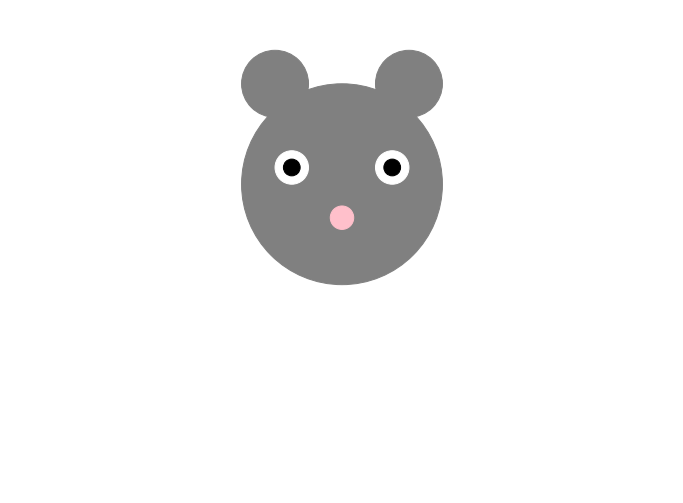

In [ ]:
# Создаем фигуру и оси
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')  # Устанавливаем цвет фона на белый

# Рисуем голову
circle_head = plt.Circle((0, 1.4), 0.6, color='gray')
ax.add_artist(circle_head)

# Рисуем уши
ear1 = plt.Circle((0.4, 2), 0.2, color='gray')
ear2 = plt.Circle((-0.4, 2), 0.2, color='gray')
ax.add_artist(ear1)
ax.add_artist(ear2)

# Рисуем глаза
eye1 = plt.Circle((-0.3, 1.5), 0.1, color='white')
eye2 = plt.Circle((0.3, 1.5), 0.1, color='white')
ax.add_artist(eye1)
ax.add_artist(eye2)

pupil1 = plt.Circle((-0.3, 1.5), 0.05, color='black')
pupil2 = plt.Circle((0.3, 1.5), 0.05, color='black')
ax.add_artist(pupil1)
ax.add_artist(pupil2)

# Рисуем нос
nose = plt.Circle((0, 1.2), 0.07, color='pink')
ax.add_artist(nose)

ax.set_aspect('equal', adjustable='datalim')
ax.axis('off')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 4)
plt.show()


### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**

только усталость, никаких мыслей и впечатлений 😅

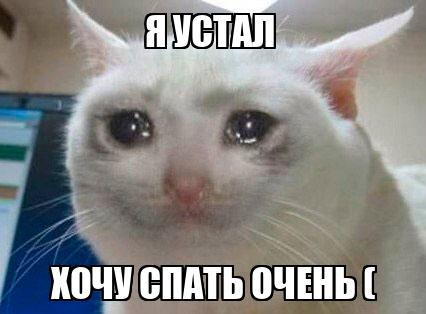

In [162]:
pip freeze > requirements.txt